In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

## Etapa 1: Aquisição e Preparação dos Dados

In [57]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=',')

In [58]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.08.2025,132.437,132.920,133.237,132.140,"8,50B","-0,48%"
1,31.07.2025,133.071,133.987,133.987,132.096,"9,20B","-0,69%"
2,30.07.2025,133.990,132.702,134.368,131.883,"8,66B","0,95%"
3,29.07.2025,132.726,132.130,133.346,132.130,"6,32B","0,45%"
4,28.07.2025,132.129,133.538,133.902,131.550,"6,63B","-1,04%"


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4953 non-null   object 
 1   Último    4953 non-null   float64
 2   Abertura  4953 non-null   float64
 3   Máxima    4953 non-null   float64
 4   Mínima    4953 non-null   float64
 5   Vol.      4952 non-null   object 
 6   Var%      4953 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB


In [60]:
df.Data = pd.to_datetime(df.Data, format='%d.%m.%Y')

In [61]:
df = df.sort_values('Data').reset_index(drop=True)

In [62]:
def convert_volume(vol_str):
    vol_str = str(vol_str).upper().replace(',', '.')
    if 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1_000_000
    elif 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1_000_000_000
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '')) * 1_000
    return float(vol_str) if pd.notna(vol_str) and vol_str != 'NAN' else 0

df['Vol.'] = df['Vol.'].apply(convert_volume)

In [63]:
df['Var%'] = df['Var%'].str.replace(',', '.').str.replace('%', '').astype(float) / 100.0

In [64]:
df.isnull().sum().sum()

np.int64(0)

In [65]:
print(df.isnull().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64


## Etapa 2: Análise Exploratória de Dados (AED)

# Evolução do Preço da Ação ao Longo do Tempo

In [66]:
fig = px.line(
    df,
    x='Data',
    y='Último',
    title='Evolução do Preço da Ação ao Longo do Tempo',
    labels={'Data': 'Data', 'Último': 'Último'},
    template='plotly_dark'
)

fig.show()

A crise de 2020, deflagrada pela pandemia de COVID-19, foi um evento global sem precedentes na história moderna, impactando simultaneamente a saúde, a economia e a sociedade em escala planetária. Diferente de outras crises financeiras, sua origem foi sanitária, o que gerou um "choque duplo" na economia: uma contração abrupta tanto da oferta quanto da demanda.

### O Estopim e a Disseminação: Uma Crise Sanitária

A crise começou a tomar forma nos primeiros dias de 2020, com a identificação de um novo coronavírus (SARS-CoV-2) em Wuhan, na China. A rápida disseminação do vírus levou a Organização Mundial da Saúde (OMS) a declarar, em 11 de março de 2020, que o mundo enfrentava uma pandemia.

A principal resposta dos governos para conter o avanço do vírus foi a implementação de medidas de distanciamento social, como lockdowns, quarentenas e restrições de circulação. Essas ações, embora necessárias do ponto de vista da saúde pública, paralisaram grande parte da atividade econômica global.

### O Choque Econômico: Demanda e Oferta em Colapso

A crise de 2020 foi única por atingir simultaneamente os dois pilares da economia:

* **Choque de Oferta:** Com o fechamento de fábricas, escritórios e comércios, a produção de bens e serviços foi drasticamente reduzida. As cadeias de suprimentos globais, altamente integradas, foram rompidas, gerando escassez de componentes e produtos acabados.
* **Choque de Demanda:** O confinamento e o medo do contágio levaram a uma queda vertiginosa no consumo das famílias. Setores como turismo, aviação, hotelaria, restaurantes e entretenimento foram praticamente paralisados. O aumento do desemprego e a incerteza em relação ao futuro fizeram com que as pessoas adiassem gastos e investimentos.

O resultado foi a recessão mais ampla e profunda desde a Segunda Guerra Mundial, com o Produto Interno Bruto (PIB) global sofrendo uma contração significativa. Mercados de ações em todo o mundo despencaram em março de 2020, refletindo o pânico e a aversão ao risco.

### Impactos no Brasil

O Brasil, assim como outras economias emergentes, foi duramente atingido. Os impactos foram sentidos em diversas frentes:

* **Recessão Econômica:** O PIB brasileiro encolheu 3,3% em 2020, segundo o IBGE. O setor de Serviços, que é o mais representativo na economia, foi o mais afetado, com uma queda de 3,7%, puxado pelo fechamento de comércios e pela redução drástica do consumo de serviços prestados às famílias. A Indústria também recuou 3,0%.
* **Mercado de Trabalho:** A crise gerou um forte aumento do desemprego e da informalidade. Milhões de postos de trabalho foram fechados, especialmente nos setores de serviços, como alojamento, alimentação e serviços domésticos. A taxa de desocupação atingiu níveis recordes.
* **Aumento da Desigualdade:** A pandemia expôs e aprofundou as desigualdades sociais existentes no país. Trabalhadores informais e populações de baixa renda foram os mais vulneráveis, perdendo suas fontes de renda de forma abrupta e tendo acesso limitado a sistemas de proteção social.

### A Resposta dos Governos e Bancos Centrais

Diante da magnitude da crise, governos e bancos centrais em todo o mundo implementaram pacotes de estímulo fiscal e monetário em uma escala sem precedentes. As principais medidas incluíram:

* **Estímulos Fiscais:** Transferências diretas de renda para a população, como o **Auxílio Emergencial** no Brasil, que foi crucial para mitigar a queda na renda das famílias mais vulneráveis e sustentar um nível mínimo de consumo. Outras medidas incluíram linhas de crédito para empresas, adiamento de impostos e aumento dos gastos públicos com saúde.
* **Estímulos Monetários:** Bancos centrais reduziram as taxas de juros a níveis historicamente baixos para baratear o crédito e estimular a atividade econômica. Também injetaram liquidez massiva nos mercados financeiros por meio da compra de títulos públicos e privados, buscando garantir o funcionamento do sistema de crédito.

Essas respostas foram fundamentais para evitar um colapso econômico ainda mais profundo, mas também geraram novos desafios, como o aumento expressivo da dívida pública na maioria dos países.

### Linha do Tempo Simplificada (Foco no Brasil)

* **Fevereiro de 2020:** O Brasil confirma o primeiro caso de COVID-19.
* **Março de 2020:** A OMS declara pandemia. Estados e municípios brasileiros começam a decretar medidas de quarentena e distanciamento social. É registrada a primeira morte no país.
* **Abril de 2020:** Início do pagamento do Auxílio Emergencial.
* **Maio/Junho de 2020:** Pico da primeira onda da pandemia no Brasil, com colapso do sistema de saúde em diversas regiões.
* **Segundo Semestre de 2020:** A economia começa a dar sinais de recuperação, impulsionada pelos estímulos governamentais e pela flexibilização das medidas de restrição. No entanto, o número de casos e óbitos permanece elevado.

Em suma, a crise de 2020 foi uma catástrofe humanitária e econômica que remodelou a sociedade global. Ela evidenciou a fragilidade das cadeias produtivas globais, a importância de sistemas de saúde pública robustos e a profundidade das desigualdades sociais, deixando lições e desafios que continuam a ser enfrentados.

## Distribuição do Resultado

In [67]:
df['Resultado'] = df['Último'].pct_change()

In [68]:
df.dropna(inplace=True)

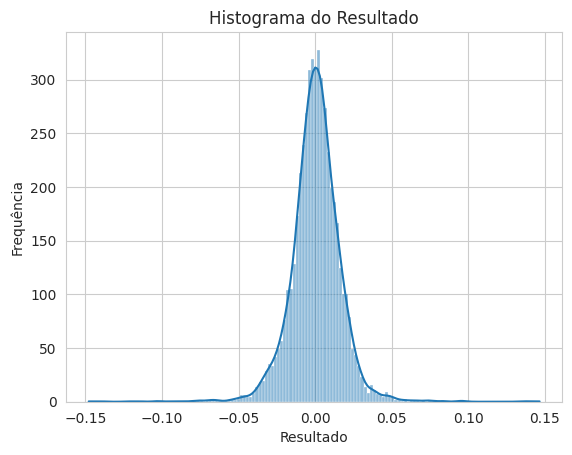

In [69]:
sns.histplot(data=df, x='Resultado', kde=True)
plt.xlabel('Resultado')
plt.ylabel('Frequência')
plt.title('Histograma do Resultado')
plt.show()

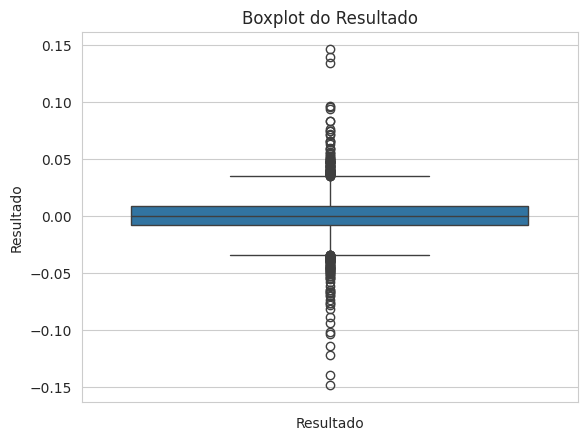

In [70]:
sns.boxplot(data=df, y='Resultado')
plt.xlabel('Resultado')
plt.title('Boxplot do Resultado')
plt.show()

### Tendo acesso ao Histograma e o Boxplot, conseguimos identificar uma distribuição simétrica dos dados

## Correlção Volume x Magnitude do Retorno

In [71]:
df['Magnitude_Retorno'] = df['Resultado'].abs()

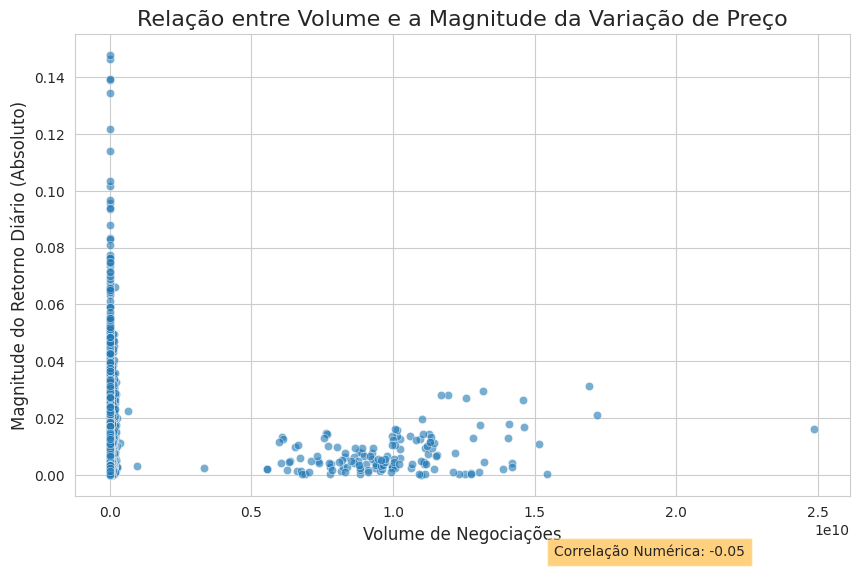


A correlação entre Volume e Magnitude do Retorno é: -0.0489


In [72]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Vol.', y='Magnitude_Retorno', data=df, alpha=0.6)

plt.title('Relação entre Volume e a Magnitude da Variação de Preço', fontsize=16)
plt.xlabel('Volume de Negociações', fontsize=12)
plt.ylabel('Magnitude do Retorno Diário (Absoluto)', fontsize=12)

correlacao = df['Vol.'].corr(df['Magnitude_Retorno'])
plt.figtext(0.7, 0.01, f'Correlação Numérica: {correlacao:.2f}', ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


plt.show()

print(f"\nA correlação entre Volume e Magnitude do Retorno é: {correlacao:.4f}")


### O coeficiente de correlação de -0.0443, calculado sobre uma robusta base de 10 anos, demonstra a ausência de uma relação linear estável entre volume e magnitude do retorno para o Ibovespa. Essa neutralidade é justificada pela agregação de múltiplos e distintos 'regimes de mercado' (crises, euforias, períodos de lateralização), cujos comportamentos individuais se anulam na média de longo prazo. Isso reforça a tese de que a relação entre essas variáveis é fundamentalmente não-linear e dependente do contexto, validando a escolha de modelos avançados capazes de capturar tais complexidades.


## Padrões Semanais

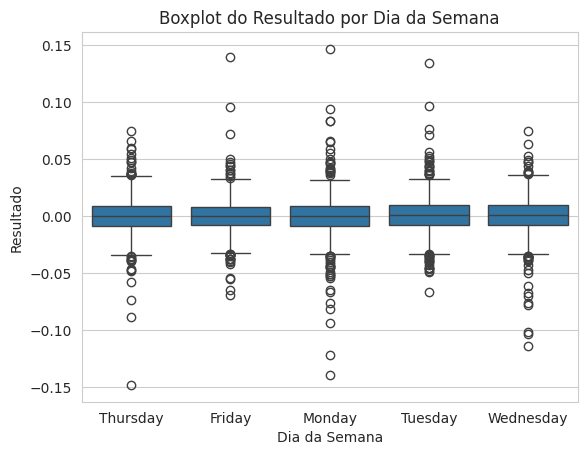

In [73]:
sns.boxplot(x=df.Data.dt.day_name(), y=df['Resultado'])
plt.xlabel('Dia da Semana')
plt.ylabel('Resultado')
plt.title('Boxplot do Resultado por Dia da Semana')
plt.show()

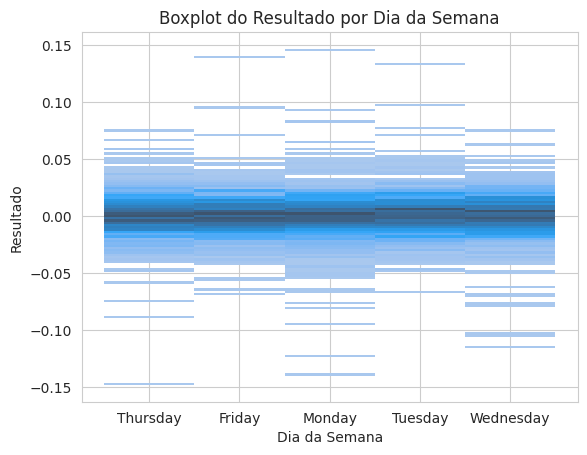

In [74]:
sns.histplot(x=df.Data.dt.day_name(), y=df['Resultado'])
plt.xlabel('Dia da Semana')
plt.ylabel('Resultado')
plt.title('Boxplot do Resultado por Dia da Semana')
plt.show()

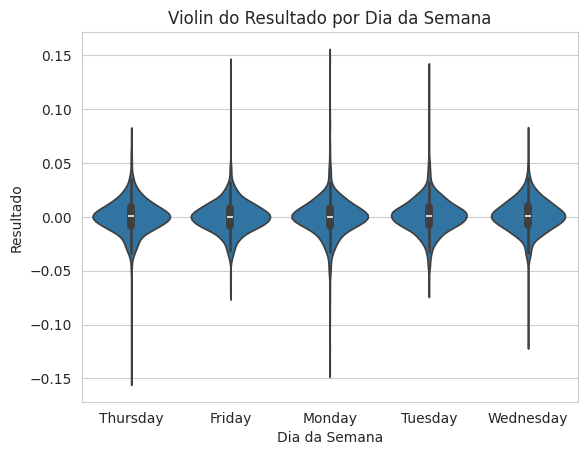

In [75]:
sns.violinplot(x=df.Data.dt.day_name(), y=df['Resultado'])
plt.xlabel('Dia da Semana')
plt.ylabel('Resultado')
plt.title('Violin do Resultado por Dia da Semana')
plt.show()

### Nossa análise exploratória, por meio deste violin plot, revelou que não existe um 'efeito dia da semana' claro e direto sobre a direção média dos retornos do Ibovespa; o comportamento típico é muito similar em todos os dias. No entanto, observamos uma sutil indicação de que a volatilidade e a ocorrência de eventos extremos podem ser ligeiramente maiores no final da semana, especialmente às sextas-feiras. Por essa razão, decidimos manter a feature 'Dia da Semana' em nosso modelo, pois ela pode conter informações valiosas sobre risco e interagir com outros indicadores para aprimorar a capacidade preditiva geral

# Etapa 3: Engenharia de Atributos

## Indicadores de Momentum: Medem a "força" do movimento atual.

### SMA

#### O Cruzamento (Sinal de Reversão de Tendência)


*   Cruzamento de Alta (Golden Cross): A linha azul (SMA_10) cruza a linha laranja (SMA_30) de baixo para cima. Isso é um forte sinal de que a tendência pode estar revertendo de baixa para alta.
*   Cruzamento de Baixa (Death Cross): A linha azul (SMA_10) cruza a linha laranja (SMA_30) de cima para baixo. Sinaliza uma possível reversão de alta para baixa.

Elas indicam que o mercado está indeciso, sem uma tendência definida. O momentum de curto prazo e a tendência de longo prazo estão em conflito, indicando um equilíbrio entre compradores e vendedores.

In [76]:
df['SMA_10'] = df['Último'].rolling(window=10).mean()
df['SMA_30'] = df['Último'].rolling(window=30).mean()

In [77]:
print(df[['Último', 'SMA_10', 'SMA_30']].tail(10))

       Último    SMA_10      SMA_30
4943  134.167  135.8888  137.323100
4944  134.036  135.3621  137.267667
4945  135.368  135.1508  137.232067
4946  133.808  134.8573  137.121400
4947  133.524  134.5910  136.978867
4948  132.129  134.2740  136.809400
4949  132.726  134.0216  136.591733
4950  133.990  133.8695  136.430067
4951  133.071  133.6201  136.241867
4952  132.437  133.5256  136.085900


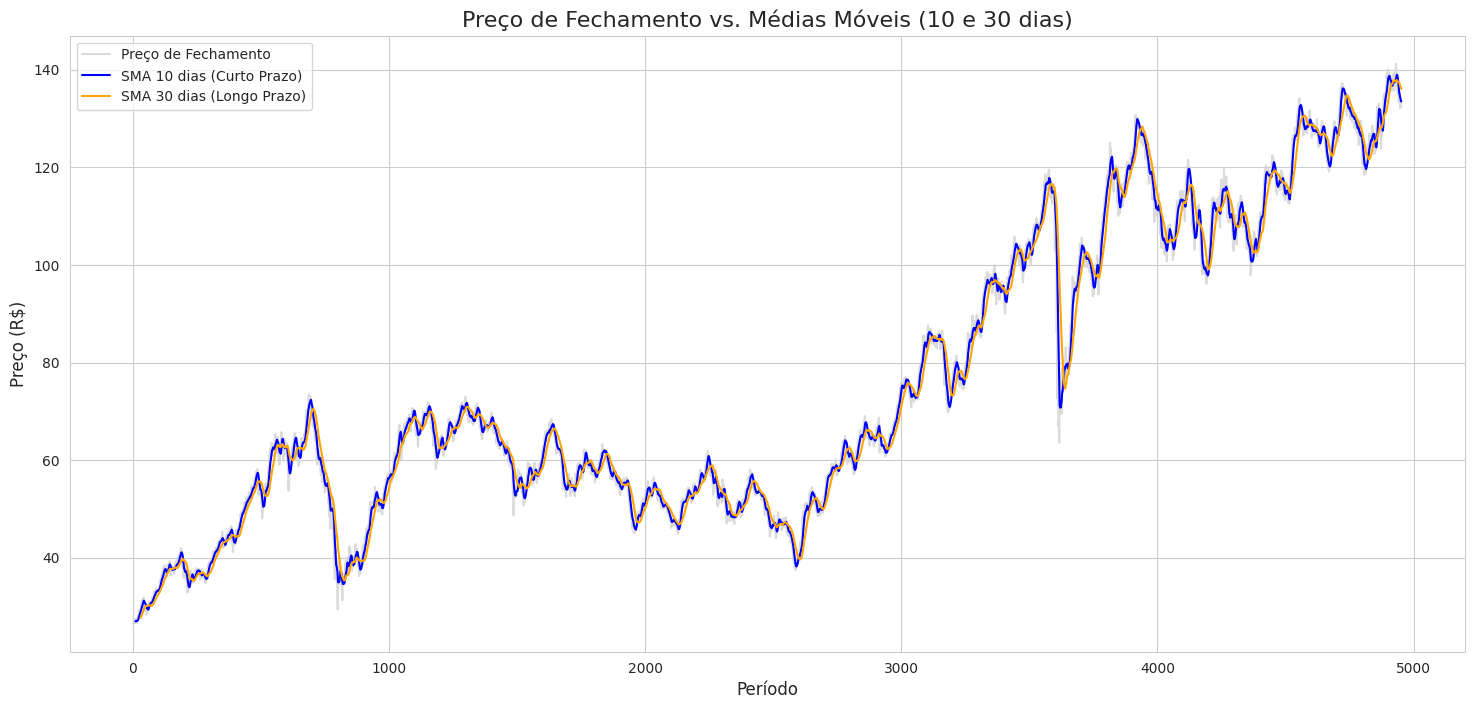

In [78]:
# Configurando o estilo e o tamanho do gráfico para melhor visualização
sns.set_style('whitegrid')
plt.figure(figsize=(18, 8))

# Plotando o preço de fechamento ('Último')
plt.plot(df.index, df['Último'], label='Preço de Fechamento', color='lightgray', alpha=0.8)

# Plotando a Média Móvel de 10 dias
plt.plot(df.index, df['SMA_10'], label='SMA 10 dias (Curto Prazo)', color='blue')

# Plotando a Média Móvel de 30 dias
plt.plot(df.index, df['SMA_30'], label='SMA 30 dias (Longo Prazo)', color='orange')

# Adicionando título e legendas para clareza
plt.title('Preço de Fechamento vs. Médias Móveis (10 e 30 dias)', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)
plt.legend()

### RSI - Relative Strength Index (RSI) - Indica sobrecompra (>70) ou sobrevenda (<30)

#### **Níveis de Sobrecompra e Sobrevenda (O Sinal Básico)**
RSI acima de 70: O ativo está na zona de sobrecompra. O preço subiu com muita força. Isso não é um sinal automático de "Venda!", mas sim um alerta de que o movimento pode estar esticado e vulnerável a uma correção.

RSI abaixo de 30: O ativo está na zona de sobrevenda. O preço caiu com muita força. Isso é um alerta de que a queda pode estar perdendo força e um repique pode estar próximo.

**Cruzamento da Linha Central (Sinal de Tendência)**

Cruzando acima de 50: O RSI subindo e cruzando a linha dos 50 indica que os compradores (bulls) estão assumindo o controle e o momentum está se tornando positivo. Confirma uma tendência de alta.

Cruzando abaixo de 50: O RSI caindo e cruzando a linha dos 50 indica que os vendedores (bears) estão no comando e o momentum é negativo. Confirma uma tendência de baixa.

**Divergências (O Sinal Avançado e Poderoso)**

Este é o sinal mais valioso do RSI. Ocorre quando o indicador e o preço "discordam".

Divergência de Baixa (Bearish Divergence): O preço faz um novo topo, mas o RSI falha e faz um topo mais baixo. Isso mostra que, apesar do novo recorde de preço, a força por trás do movimento está diminuindo. É um aviso clássico de que o topo pode estar próximo.

Divergência de Alta (Bullish Divergence): O preço faz um novo fundo, mas o RSI faz um fundo mais alto. Isso mostra que a força vendedora está se esgotando. Mesmo com o novo preço mínimo, o momentum da queda está diminuindo. É um sinal forte de que o fundo pode estar se formando.

In [79]:
delta = df['Último'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [80]:
print(df[['Último', 'RSI']].tail(10))

       Último        RSI
4943  134.167  27.589940
4944  134.036  28.459754
4945  135.368  24.945926
4946  133.808  19.740260
4947  133.524  22.456140
4948  132.129  20.202691
4949  132.726  28.012577
4950  133.990  37.860482
4951  133.071  36.686037
4952  132.437  37.500000


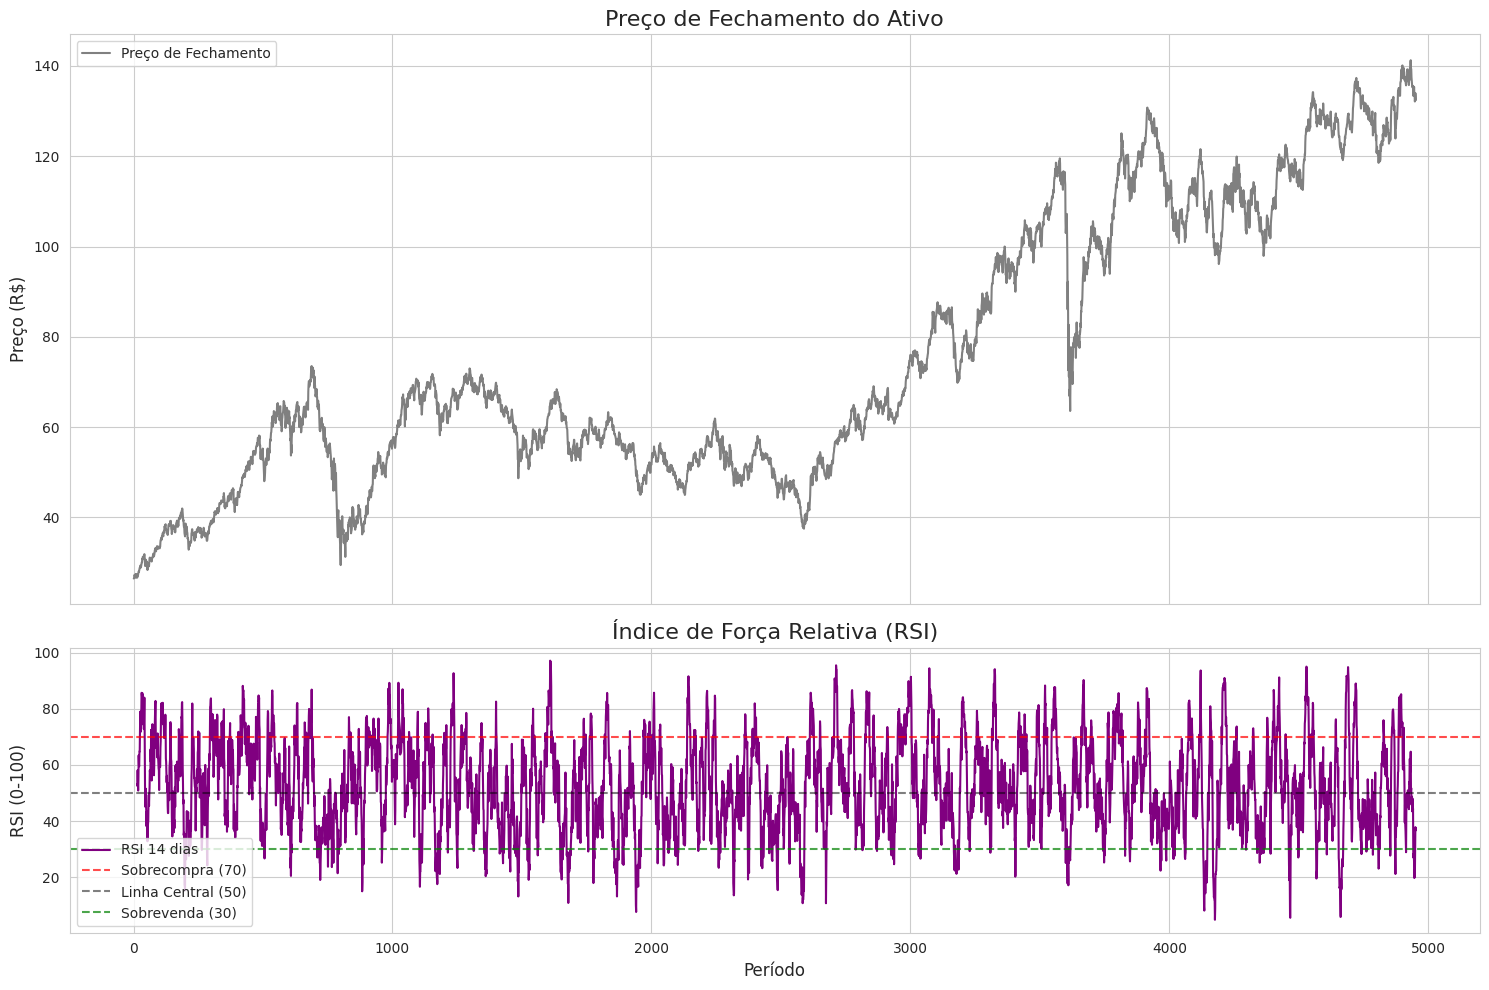

In [81]:
# Configurando o estilo e criando uma figura com 2 subplots (um em cima do outro)
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Gráfico Superior (Preço) ---
ax1.plot(df.index, df['Último'], label='Preço de Fechamento', color='gray')
ax1.set_title('Preço de Fechamento do Ativo', fontsize=16)
ax1.set_ylabel('Preço (R$)', fontsize=12)
ax1.legend()
ax1.grid(True)

# --- Gráfico Inferior (RSI) ---
ax2.plot(df.index, df['RSI'], label='RSI 14 dias', color='purple')

# Adicionando as linhas de referência cruciais para a análise
ax2.axhline(70, linestyle='--', color='red', alpha=0.7, label='Sobrecompra (70)')
ax2.axhline(50, linestyle='--', color='black', alpha=0.5, label='Linha Central (50)')
ax2.axhline(30, linestyle='--', color='green', alpha=0.7, label='Sobrevenda (30)')

ax2.set_title('Índice de Força Relativa (RSI)', fontsize=16)
ax2.set_ylabel('RSI (0-100)', fontsize=12)
ax2.set_xlabel('Período', fontsize=12)
ax2.legend()
ax2.grid(True)

# Exibindo os gráficos
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

## Indicadores de Volatilidade: Medem o "risco" ou o "nervosismo" do mercado.

### Desvio Padrão dos Retornos:

#### Nossa análise da volatilidade histórica, ilustrada neste gráfico, revela o fenômeno de 'clustering', onde períodos de calma e estresse no mercado ocorrem em regimes bem definidos. O pico observado em meados do período, representando a crise de 2020, demonstra como um choque pode elevar o patamar de risco por um longo tempo.

In [82]:
df['Volatility_10'] = df['Resultado'].rolling(window=10).std()
df['Volatility_30'] = df['Resultado'].rolling(window=30).std()

In [83]:
print(df[['Resultado', 'Volatility_10', 'Volatility_30']].tail(10))

      Resultado  Volatility_10  Volatility_30
4943   0.005885       0.006745       0.008010
4944  -0.000976       0.006761       0.007997
4945   0.009938       0.007167       0.008151
4946  -0.011524       0.007773       0.008339
4947  -0.002122       0.007743       0.008273
4948  -0.010448       0.008093       0.008432
4949   0.004518       0.008368       0.007947
4950   0.009523       0.009064       0.008195
4951  -0.006859       0.009221       0.008260
4952  -0.004764       0.007867       0.008062


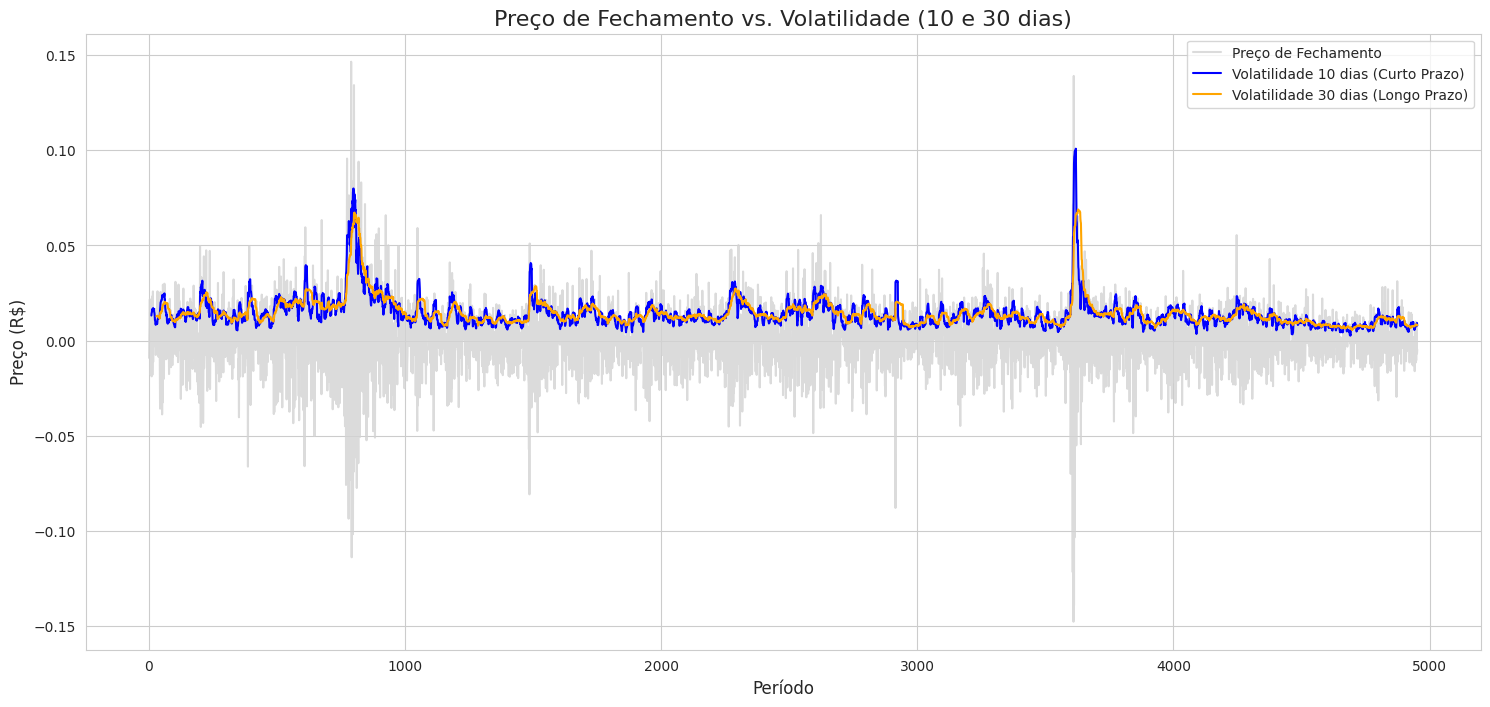

In [84]:
# Configurando o estilo e o tamanho do gráfico para melhor visualização
sns.set_style('whitegrid')
plt.figure(figsize=(18, 8))

# Plotando o preço de fechamento ('Último')
plt.plot(df.index, df['Resultado'], label='Preço de Fechamento', color='lightgray', alpha=0.8)

# Plotando a Média Móvel de 10 dias
plt.plot(df.index, df['Volatility_10'], label='Volatilidade 10 dias (Curto Prazo)', color='blue')

# Plotando a Média Móvel de 30 dias
plt.plot(df.index, df['Volatility_30'], label='Volatilidade 30 dias (Longo Prazo)', color='orange')

# Adicionando título e legendas para clareza
plt.title('Preço de Fechamento vs. Volatilidade (10 e 30 dias)', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)
plt.legend()

## Atributos Defasados (Lags): Informam ao modelo o que aconteceu nos dias imediatamente anteriores.

### Nossa análise de autocorrelação, feita através da matriz de correlação, revelou uma fraca tendência de reversão à média no prazo de 1 dia (correlação de -0.1). Isso sugere que o mercado tende a corrigir levemente os movimentos do dia anterior. No entanto, essa 'memória' é muito curta, pois a correlação se torna estatisticamente insignificante para retornos de 2 dias ou mais, indicando que a informação passada é rapidamente absorvida pelo preço.

In [85]:
for i in range(1, 6):
  df[f'Lag_Retorno_{i}'] = df['Resultado'].shift(i)
# Features de Data
df['Dia_da_semana'] = df['Data'].dt.dayofweek

In [86]:
corr_matrix = df[['Resultado', 'Lag_Retorno_1', 'Lag_Retorno_2', 'Lag_Retorno_3', 'Lag_Retorno_4', 'Lag_Retorno_5']].corr()

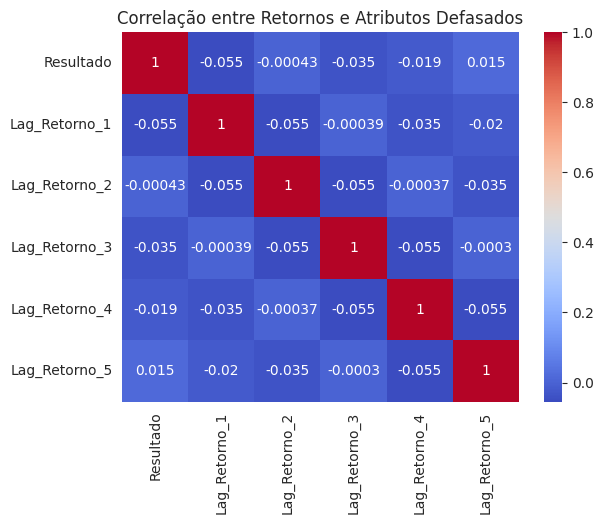

In [87]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre Retornos e Atributos Defasados')
plt.show()

In [88]:
# Mapeia os números para nomes para facilitar a leitura
dias_map = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta'}
df['Nome_Dia'] = df['Dia_da_semana'].map(dias_map)

# Agrupa e calcula a média e o desvio padrão (volatilidade) dos retornos
analise_semanal = df.groupby('Nome_Dia')['Resultado'].agg(['mean', 'std', 'sum', 'count'])
print(analise_semanal)

              mean       std       sum  count
Nome_Dia                                     
Quarta    0.000834  0.016465  0.838231   1005
Quinta    0.000334  0.016240  0.330104    989
Segunda  -0.000245  0.018397 -0.241190    986
Sexta     0.000145  0.015258  0.142470    982
Terça     0.001222  0.016096  1.209404    990


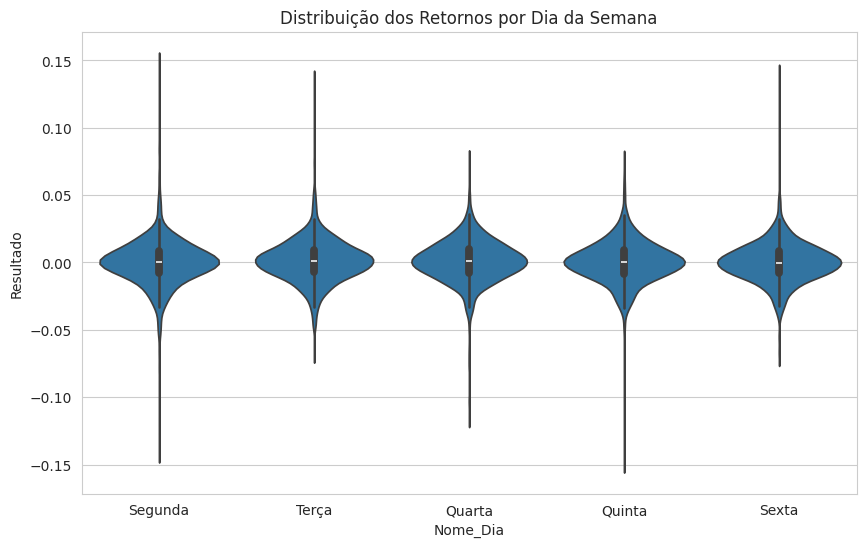

In [89]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Nome_Dia', y='Resultado', data=df, order=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])
plt.title('Distribuição dos Retornos por Dia da Semana')
plt.show()

# Etapa 4: Preparação Final para o Modelo

In [90]:
df.drop('Nome_Dia', axis=1, inplace=True)

In [91]:
#Diferença entre Médias Móveis: Esta é uma das features mais clássicas e poderosas.
df['SMA_Diff'] = df['SMA_10'] - df['SMA_30']

In [92]:
#Preço vs. Média Longa: Quão "esticado" está o preço em relação à sua tendência principal?
df['Price_vs_SMA30'] = df['Último'] / df['SMA_30'] - 1

In [93]:
#Posição Relativa no RSI: Transforme os níveis do RSI em categorias.
df['RSI_Signal'] = pd.cut(df['RSI'], bins=[0, 30, 70, 100], labels=[-1, 0, 1])

In [94]:
ema_12 = df['Último'].ewm(span=12, adjust=False).mean()
ema_26 = df['Último'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
# Linha de Sinal do MACD
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [95]:
# Média de 20 dias (padrão para Bollinger)
df['SMA_20'] = df['Último'].rolling(window=20).mean()
# Desvio padrão de 20 dias
std_20 = df['Último'].rolling(window=20).std()
# Banda Superior
df['Bollinger_Upper'] = df['SMA_20'] + (std_20 * 2)
# Banda Inferior
df['Bollinger_Lower'] = df['SMA_20'] - (std_20 * 2)

In [96]:
df['RSI_Diff_3D'] = df['RSI'].diff(3)

In [97]:
# Cria uma feature '1' se a volatilidade de longo prazo está alta, e '0' se está baixa
vol_threshold = df['Volatility_30'].quantile(0.75) # Define o que é "volatilidade alta"
df['Regime_Alta_Vol'] = (df['Volatility_30'] > vol_threshold).astype(int)

In [98]:
df['Price_vs_Upper_Band'] = df['Último'] - df['Bollinger_Upper']
df['Price_vs_Lower_Band'] = df['Último'] - df['Bollinger_Lower']
df['Percent_B'] = (df['Último'] - df['Bollinger_Lower']) / (df['Bollinger_Upper'] - df['Bollinger_Lower'])

In [99]:
df.dropna(inplace=True)

In [100]:
#Target
limiar = 0.005  # 0.5%
df['Retorno'] = df['Último'].pct_change().shift(-1)
df['Target'] = (df['Retorno'] > limiar).astype(int)
df.dropna(subset=['Retorno'], inplace=True)

In [101]:
#Seleção das melhores features
features = ['Vol.', 'RSI', 'Volatility_30', 'Lag_Retorno_1', 'Lag_Retorno_2']
X = df[features]
y = df['Target']

In [102]:
#Divisão Treino - Teste
teste_size = 30
X_train, X_test = X[:-teste_size], X[-teste_size:]
y_train, y_test = y[:-teste_size], y[-teste_size:]

In [103]:
#Treinamento
# Balanceamento de classes
contagem = y_train.value_counts()
peso = contagem[0] / contagem[1] if 1 in contagem else 1.0

modelo = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    num_leaves=20,
    scale_pos_weight=peso,
    random_state=42
)

modelo.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1777, number of negative: 3115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4892, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363246 -> initscore=-0.561303
[LightGBM] [Info] Start training from score -0.561303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(learning_rate=0.05, max_depth=10, n_estimators=300,
               num_leaves=20, random_state=42,
               scale_pos_weight=np.float64(1.7529544175576814))


🎯 Acurácia: 80.00%

📊 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        24
           1       0.50      0.33      0.40         6

    accuracy                           0.80        30
   macro avg       0.67      0.62      0.64        30
weighted avg       0.78      0.80      0.78        30



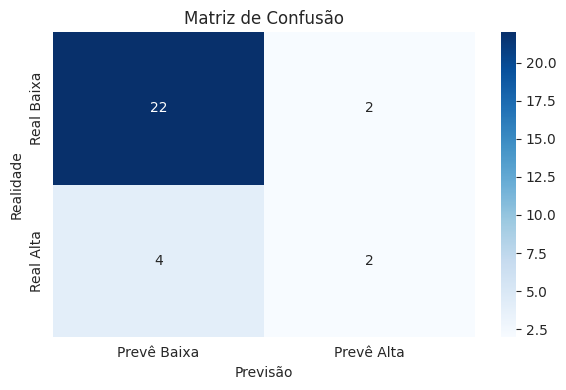

In [104]:
#Avaliando o modelo
y_pred = modelo.predict(X_test)

print(f"\n🎯 Acurácia: {accuracy_score(y_test, y_pred):.2%}")
print("\n📊 Relatório de Classificação:")
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prevê Baixa', 'Prevê Alta'],
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Realidade')
plt.tight_layout()
plt.show()